<a href="https://colab.research.google.com/github/jrgreen7/SYSC4906/blob/master/DataImputation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Notebook to illustrate the effect of missing data during training and testing

Created by James Green, 24 Sept 2019

Portions are based on "An example machine learning notebook", by Randal S. Olson, University of Pennsylvania Institute for Bioinformatics

1. Load the original Iris Dataset (https://raw.githubusercontent.com/jrgreen7/SYSC4906/master/orig-iris-data.csv)
2. Split data into train/test (50/50)
3. For i = 10:10:50%
    - Remove i% of the training data from one feature
    - Impute missing data using mean of all data from that class
    - Train classifier
    - Test classifier
    - Report score along with i
    - Remove training rows with NaN values, retrain, retest


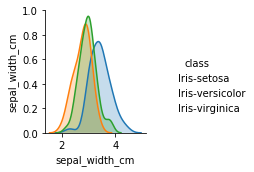

In [1]:
# Import libraries
import pandas as pd

# Load the dataset
url = 'https://raw.githubusercontent.com/jrgreen7/SYSC4906/master/orig-iris-data.csv'
iris_data = pd.read_csv(url)
# Note that iris = seaborn.load_dataset("iris") would also work (with diff column names)

# Quickly visualize first few rows
iris_data.head()

# Drop all features except petal_width_cm
iris_data.drop(['sepal_length_cm', 'petal_length_cm', 'petal_width_cm'], axis=1, inplace=True)

# Describe the data (gives range of each feature, etc)
iris_data.describe()

# Plot the features, in pairs
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb
sb.pairplot(iris_data.dropna(), hue='class'); # Dropping NA values, but shouldn't be any yet...

# Split the data (doing this in Pandas rather than using sklearn)
iris_data_copy = iris_data.copy()
train_set = iris_data_copy.sample(frac=0.5, random_state=0)
test_set = iris_data_copy.drop(train_set.index)


In [3]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier

# Vary the amount of missing feature values from 10% to 70%
for i in np.linspace(0.1, 0.7, num=7):
  missingRows = train_set.sample(frac=i, random_state=1)
  train_set_copy = train_set.copy()
  train_set_copy.loc[missingRows.index, 'sepal_width_cm'] = np.NaN; # Replace missing rows with NaN for sepal_width_cm feature

  # Remove the missing rows prior to computing the mean of the feature:
  train_set_noNA = train_set_copy.dropna(inplace=False)

  # Compute the average petal width, for each class (yes, I'm computing the mean before removing rows...)
  average_petal_width1 = train_set_noNA.loc[train_set_noNA['class'] == 'Iris-setosa', 'sepal_width_cm'].mean()
  average_petal_width2 = train_set_noNA.loc[train_set_noNA['class'] == 'Iris-versicolor', 'sepal_width_cm'].mean()
  average_petal_width3 = train_set_noNA.loc[train_set_noNA['class'] == 'Iris-virginica', 'sepal_width_cm'].mean()
  
  # Replace missing values with the mean value for that class
  train_set_copy.loc[(train_set_copy['class'] == 'Iris-setosa') &
              (train_set_copy['sepal_width_cm'].isnull()),
              'sepal_width_cm'] = average_petal_width1
  train_set_copy.loc[(train_set_copy['class'] == 'Iris-versicolor') &
              (train_set_copy['sepal_width_cm'].isnull()),
              'sepal_width_cm'] = average_petal_width2
  train_set_copy.loc[(train_set_copy['class'] == 'Iris-virginica') &
              (train_set_copy['sepal_width_cm'].isnull()),
              'sepal_width_cm'] = average_petal_width3

  #train_set_copy.loc[(train_set_copy['class'] == 'Iris-setosa') &
  #            (train_set_copy['sepal_width_cm']== average_petal_width1),
  #            'sepal_width_cm'] 

  # Extract the data/classes from pandas into nparrays:
  features = train_set_copy['sepal_width_cm'].values.reshape(-1,1)
  labels = train_set_copy['class'].values.reshape(-1,1)

  # Train a DT classifier with imputation
  decision_tree_classifier = DecisionTreeClassifier()
  decision_tree_classifier.fit(features, labels)

  # Test a DT classifier
  test_features = test_set['sepal_width_cm'].values.reshape(-1,1)
  test_labels = test_set['class'].values.reshape(-1,1)
  score = decision_tree_classifier.score(test_features, test_labels)

  # Train a DT classifier without imputation
  features_noNA = train_set_noNA['sepal_width_cm'].values.reshape(-1,1)
  labels_noNA = train_set_noNA['class'].values.reshape(-1,1)
  decision_tree_classifier2 = DecisionTreeClassifier()
  decision_tree_classifier2.fit(features_noNA, labels_noNA)
  score_noNA = decision_tree_classifier2.score(test_features, test_labels)


  # Print the score:
  print('For {:.0f}% missing data, imputation test accuracy is {:.2f}, dropping rows achieves {:.2f}'.format(i*100, score, score_noNA))

For 10% missing data, imputation test accuracy is 0.49, dropping rows achieves 0.49
For 20% missing data, imputation test accuracy is 0.45, dropping rows achieves 0.45
For 30% missing data, imputation test accuracy is 0.43, dropping rows achieves 0.43
For 40% missing data, imputation test accuracy is 0.49, dropping rows achieves 0.49
For 50% missing data, imputation test accuracy is 0.55, dropping rows achieves 0.53
For 60% missing data, imputation test accuracy is 0.60, dropping rows achieves 0.55
For 70% missing data, imputation test accuracy is 0.49, dropping rows achieves 0.49


## Discussion
What if feature data were missing from the test data? How would you impute the missing feature values? Would it have more or less of an effect than missing data during training?